In [68]:
%pip install pyyaml==6.0.1
%pip install pycocotools>=2.0.7
%pip install torch==2.2.1+cu121 torchvision==0.17.1+cu121 -f https://download.pytorch.org/whl/torch_stable.html
%pip install opencv-python
%pip install tensorboard
import sys, os, distutils.core
# Note: This is a faster way to install detectron2 in Colab, but it does not include all functionalities (e.g. compiled operators).
# See https://detectron2.readthedocs.io/tutorials/install.html for full installation instructions
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

Defaulting to user installation because normal site-packages is not writeable
DEPRECATION: flatbuffers 1.12.1-git20200711.33e2d80-dfsg1-0.6 has a non-standard version number. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of flatbuffers or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
Note: you may need to restart the kernel to use updated packages.
DEPRECATION: flatbuffers 1.12.1-git20200711.33e2d80-dfsg1-0.6 has a non-standard version number. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of flatbuffers or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation becaus

In [1]:
import os
import json
import random
import cv2
import torch
from torch.utils.data import DataLoader, random_split
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from torch import __version__ as torch_ver
from detectron2 import __version__ as detectron_ver
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor, DefaultTrainer
from detectron2.modeling import GeneralizedRCNN
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.data import MetadataCatalog, DatasetCatalog, build_detection_test_loader, build_detection_train_loader, DatasetMapper
from detectron2.data.datasets import register_coco_instances, load_coco_json
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.utils.logger import setup_logger
from detectron2.structures import BoxMode
logger = setup_logger()

In [2]:
TORCH_VERSION = ".".join(torch_ver.split(".")[:2])
CUDA_VERSION = torch_ver.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron_ver)
print("gpu:", torch.cuda.is_available())

torch:  2.2 ; cuda:  cu121
detectron2: 0.6
gpu: True


In [3]:
MODEL = "COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"
OUTPUT_DIR = "./output"
DATASET_NAME = "agar_coco_dataset"
DATASET_PATH = "./DATASET_BIG/dataset/"
ANNOTATION_FILE_PATH = "./DATASET_BIG/dataset/annotations.json"
TRAINING_LISTS_PATH = "./DATASET_BIG/training_lists/"
CATEGORIES = ["S.aureus",
              "B.subtilis",
              "P.aeruginosa",
              "E.coli",
              "C.albicans"]  # исключили классы Defect и Contamination
CATEGORIES_DICT = {0: "S.aureus",
                   1: "B.subtilis",
                   2: "P.aeruginosa",
                   3: "E.coli",
                   4: "C.albicans"}  # исключили классы Defect и Contamination

In [4]:
# !unzip -o ./NOTEBOOK/DATASETS.zip -d ./

17423.jpg


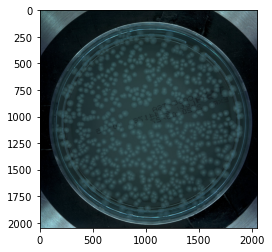

In [5]:
img = str(random.randint(1, 18000)) + ".jpg"
print(img)
im = cv2.imread(f"{DATASET_PATH}{img}")
plt.imshow(im)
plt.show()

In [6]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file(MODEL))
cfg

CfgNode({'VERSION': 2, 'MODEL': CfgNode({'LOAD_PROPOSALS': False, 'MASK_ON': False, 'KEYPOINT_ON': False, 'DEVICE': 'cuda', 'META_ARCHITECTURE': 'GeneralizedRCNN', 'WEIGHTS': 'detectron2://ImageNetPretrained/MSRA/R-50.pkl', 'PIXEL_MEAN': [103.53, 116.28, 123.675], 'PIXEL_STD': [1.0, 1.0, 1.0], 'BACKBONE': CfgNode({'NAME': 'build_resnet_fpn_backbone', 'FREEZE_AT': 2}), 'FPN': CfgNode({'IN_FEATURES': ['res2', 'res3', 'res4', 'res5'], 'OUT_CHANNELS': 256, 'NORM': '', 'FUSE_TYPE': 'sum'}), 'PROPOSAL_GENERATOR': CfgNode({'NAME': 'RPN', 'MIN_SIZE': 0}), 'ANCHOR_GENERATOR': CfgNode({'NAME': 'DefaultAnchorGenerator', 'SIZES': [[32], [64], [128], [256], [512]], 'ASPECT_RATIOS': [[0.5, 1.0, 2.0]], 'ANGLES': [[-90, 0, 90]], 'OFFSET': 0.0}), 'RPN': CfgNode({'HEAD_NAME': 'StandardRPNHead', 'IN_FEATURES': ['p2', 'p3', 'p4', 'p5', 'p6'], 'BOUNDARY_THRESH': -1, 'IOU_THRESHOLDS': [0.3, 0.7], 'IOU_LABELS': [0, -1, 1], 'BATCH_SIZE_PER_IMAGE': 256, 'POSITIVE_FRACTION': 0.5, 'BBOX_REG_LOSS_TYPE': 'smooth_l

In [7]:
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7  # set threshold for this model
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(MODEL)
cfg.MODEL.DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
predictor = DefaultPredictor(cfg)
outputs = predictor(im)

[04/06 02:12:43 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-Detection/faster_rcnn_R_50_FPN_3x/137849458/model_final_280758.pkl ...


/home/user/.local/lib/python3.10/site-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [8]:
print("pred_boxes:", outputs["instances"].pred_boxes)
print("scores:", outputs["instances"].scores)
print("pred_classes:", outputs["instances"].pred_classes)

pred_boxes: Boxes(tensor([], device='cuda:0', size=(0, 4)))
scores: tensor([], device='cuda:0')
pred_classes: tensor([], device='cuda:0', dtype=torch.int64)


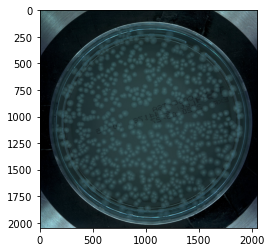

In [9]:
v = Visualizer(
    im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.0)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.imshow(out.get_image()[:, :, ::-1])

In [10]:
def get_ids_by_train_list(training_list_path: str) -> list[dict]:
    with open(training_list_path, 'r') as f:
        data = f.read()
    j = json.loads(data)
    str_ids = [num for num in j if num != 'annotations.json']
    ids = [int(num) for num in str_ids]
    return ids


def filter_dataset_by_ids(dataset: list[dict], ids: list[int]) -> list[dict]:
    return [ann for ann in dataset if ann['image_id'] in ids]


def filter_annotations_by_categories(dataset: list[dict], categories_dict: dict[int, str]):
    for d in dataset:
        d["annotations"] = [ann for ann in d["annotations"]
                            if ann["category_id"] in list(categories_dict.keys())]
    return dataset

In [11]:
agar_coco_full_dataset = load_coco_json(json_file=ANNOTATION_FILE_PATH,
                                        image_root=DATASET_PATH,
                                        dataset_name=DATASET_NAME)
agar_coco_full_dataset = filter_annotations_by_categories(
    agar_coco_full_dataset, CATEGORIES_DICT)

[04/06 02:12:50 d2.data.datasets.coco]: Loading ./DATASET_BIG/dataset/annotations.json takes 3.18 seconds.
[04/06 02:12:50 d2.data.datasets.coco]: Loaded 18000 images in COCO format from ./DATASET_BIG/dataset/annotations.json


In [12]:
high_res_train_list_path = f"{TRAINING_LISTS_PATH}higher_resolution_train.txt"
low_res_train_list_path = f"{TRAINING_LISTS_PATH}lower_resolution_train.txt"
vague_train_list_path = f"{TRAINING_LISTS_PATH}vague_train.txt"
high_res_val_list_path = f"{TRAINING_LISTS_PATH}higher_resolution_val.txt"
low_res_val_list_path = f"{TRAINING_LISTS_PATH}lower_resolution_val.txt"
vague_val_list_path = f"{TRAINING_LISTS_PATH}vague_val.txt"

In [13]:
# делим на тренировочный и тестовый датасеты с изображениями
# высокого качества, низкого качества и расплывчатые (всего 6)
for k, v in {"high_res_train": high_res_train_list_path,
             "low_res_train": low_res_train_list_path,
             "vague_train": vague_train_list_path,
             "high_res_val": high_res_val_list_path,
             "low_res_val": low_res_val_list_path,
             "vague_val": vague_val_list_path}.items():
    name = f"{DATASET_NAME}_{k}"
    try:
        DatasetCatalog.remove(name)
        MetadataCatalog.remove(name)
    except:
        pass
    print("Registering '{}' DatasetCatalog by path {}".format(name, v))
    DatasetCatalog.register(name, lambda v=v:
                            filter_dataset_by_ids(dataset=agar_coco_full_dataset,
                                                  ids=get_ids_by_train_list(v)))
    MetadataCatalog.get(name).set(thing_classes=CATEGORIES)
    MetadataCatalog.get(name).set(image_root=DATASET_PATH)
    MetadataCatalog.get(name).set(evaluator_type='coco')
    print("Successfully registered '{}' DatasetCatalog containing {} indices".format(
        name, len(DatasetCatalog.get(name))))
    print("Metadata of {}: {}\n".format(name, MetadataCatalog.get(name)))

Registering 'agar_coco_dataset_high_res_train' DatasetCatalog by path ./DATASET_BIG/training_lists/higher_resolution_train.txt
Successfully registered 'agar_coco_dataset_high_res_train' DatasetCatalog containing 5241 indices
Metadata of agar_coco_dataset_high_res_train: Metadata(name='agar_coco_dataset_high_res_train', thing_classes=['S.aureus', 'B.subtilis', 'P.aeruginosa', 'E.coli', 'C.albicans'], image_root='./DATASET_BIG/dataset/', evaluator_type='coco')

Registering 'agar_coco_dataset_low_res_train' DatasetCatalog by path ./DATASET_BIG/training_lists/lower_resolution_train.txt
Successfully registered 'agar_coco_dataset_low_res_train' DatasetCatalog containing 3318 indices
Metadata of agar_coco_dataset_low_res_train: Metadata(name='agar_coco_dataset_low_res_train', thing_classes=['S.aureus', 'B.subtilis', 'P.aeruginosa', 'E.coli', 'C.albicans'], image_root='./DATASET_BIG/dataset/', evaluator_type='coco')

Registering 'agar_coco_dataset_vague_train' DatasetCatalog by path ./DATASET_

./DATASET_BIG/dataset/16786.jpg


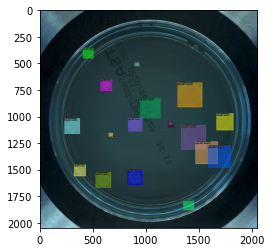

In [14]:
# To verify the dataset is in correct format,
# let's visualize the annotations of randomly selected samples in the training set
for d in random.sample(DatasetCatalog.get(f"{DATASET_NAME}_low_res_train"), 1):
    print(d["file_name"])
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1],
                            metadata=MetadataCatalog.get(f"{DATASET_NAME}_low_res_train"),
                            scale=1.0)
    out = visualizer.draw_dataset_dict(d)
    plt.imshow(out.get_image()[:, :, ::-1])
    plt.show()

In [17]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file(MODEL))
cfg.DATASETS.TRAIN = (f"{DATASET_NAME}_high_res_train",
                      f"{DATASET_NAME}_low_res_train",
                      f"{DATASET_NAME}_vague_train")
cfg.DATASETS.TEST = (f"{DATASET_NAME}_high_res_val",
                     f"{DATASET_NAME}_low_res_val",
                     f"{DATASET_NAME}_vague_val")
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(MODEL)
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.MAX_ITER = 50_000
cfg.SOLVER.STEPS = (10_000,)
cfg.SOLVER.BASE_LR = 0.00025
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 5
cfg.TEST.DETECTIONS_PER_IMAGE = 300
cfg.MODEL.DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
cfg.DATALOADER.FILTER_EMPTY_ANNOTATIONS = False  # под вопросом
# Minimum size of the side of the image during training
cfg.INPUT.MIN_SIZE_TRAIN = (1024, 1024)
# Maximum size of the side of the image during training
cfg.INPUT.MAX_SIZE_TRAIN = 2048
# Size of the smallest side of the image during testing. Set to zero to disable resize in testing.
cfg.INPUT.MIN_SIZE_TEST = (1024, 1024)
# Maximum size of the side of the image during testing
cfg.INPUT.MAX_SIZE_TEST = 2048
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

In [18]:
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=True)

print(f"Start training on {cfg.MODEL.DEVICE}")
trainer.train()

[04/06 03:09:19 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

In [ ]:
%ls ./output/ | grep '.pth'

33749.78s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


model_final.pth


In [ ]:
# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

[04/05 23:57:43 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...


./DATASET_BIG/dataset/15256.jpg


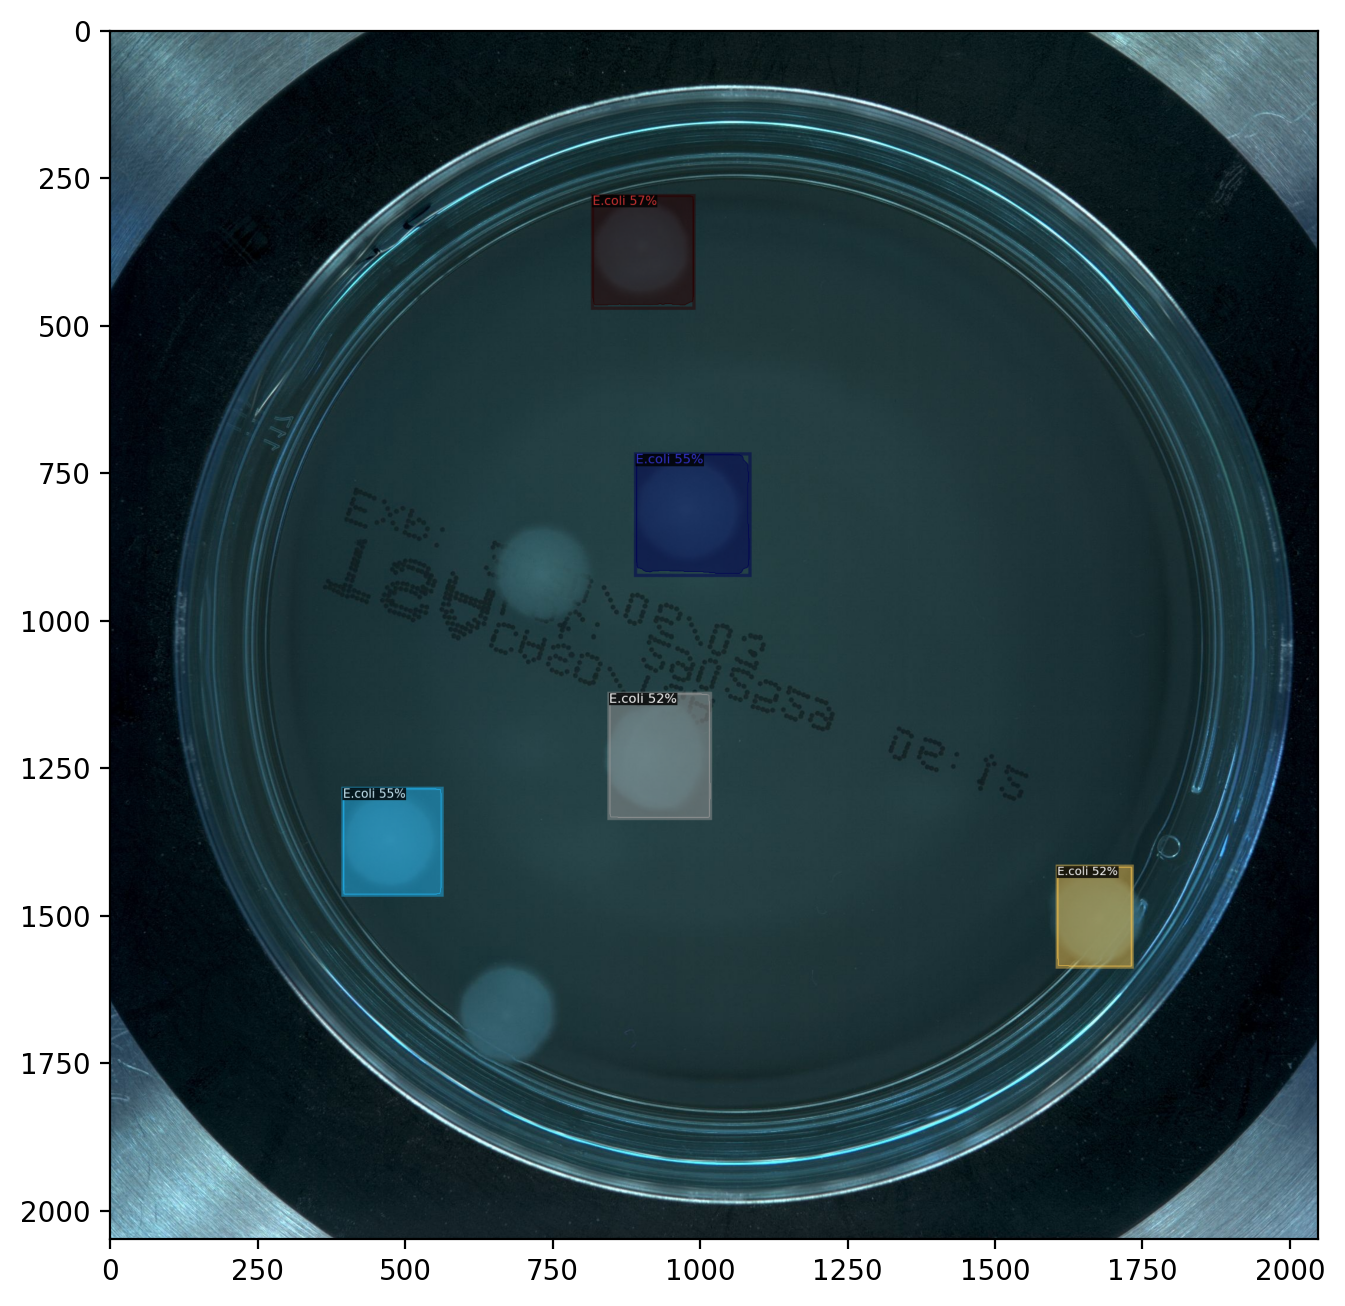

./DATASET_BIG/dataset/15866.jpg


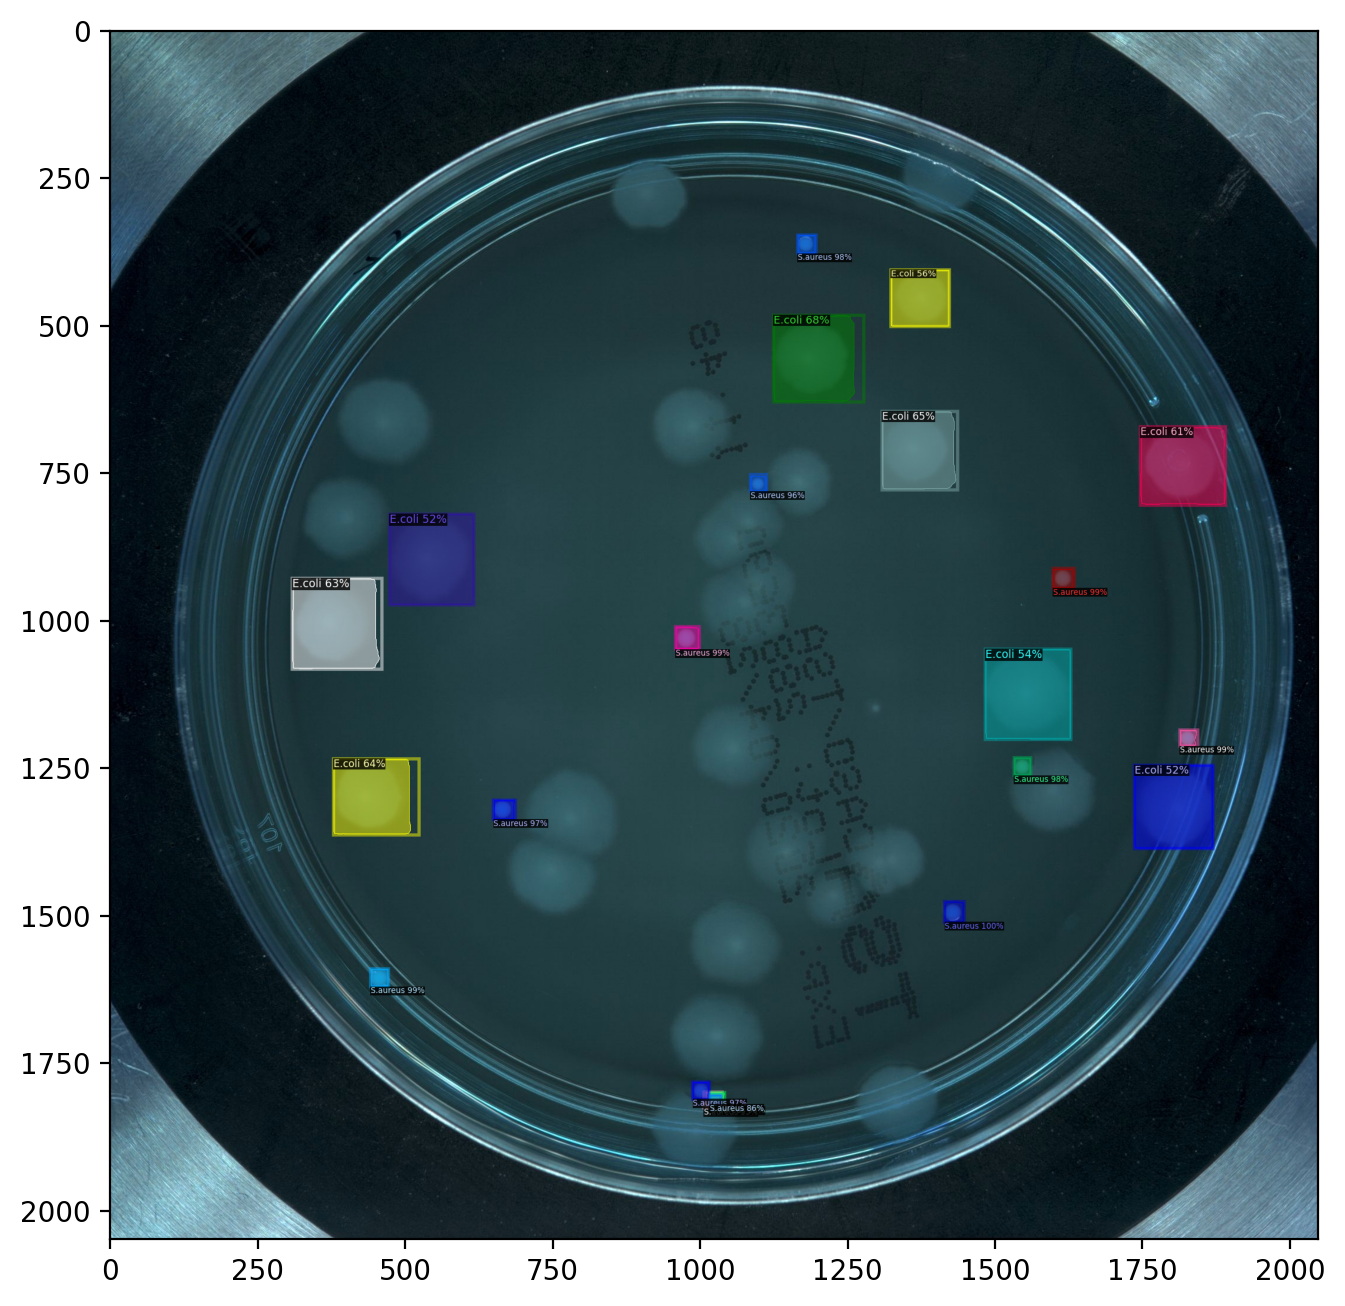

./DATASET_BIG/dataset/11931.jpg


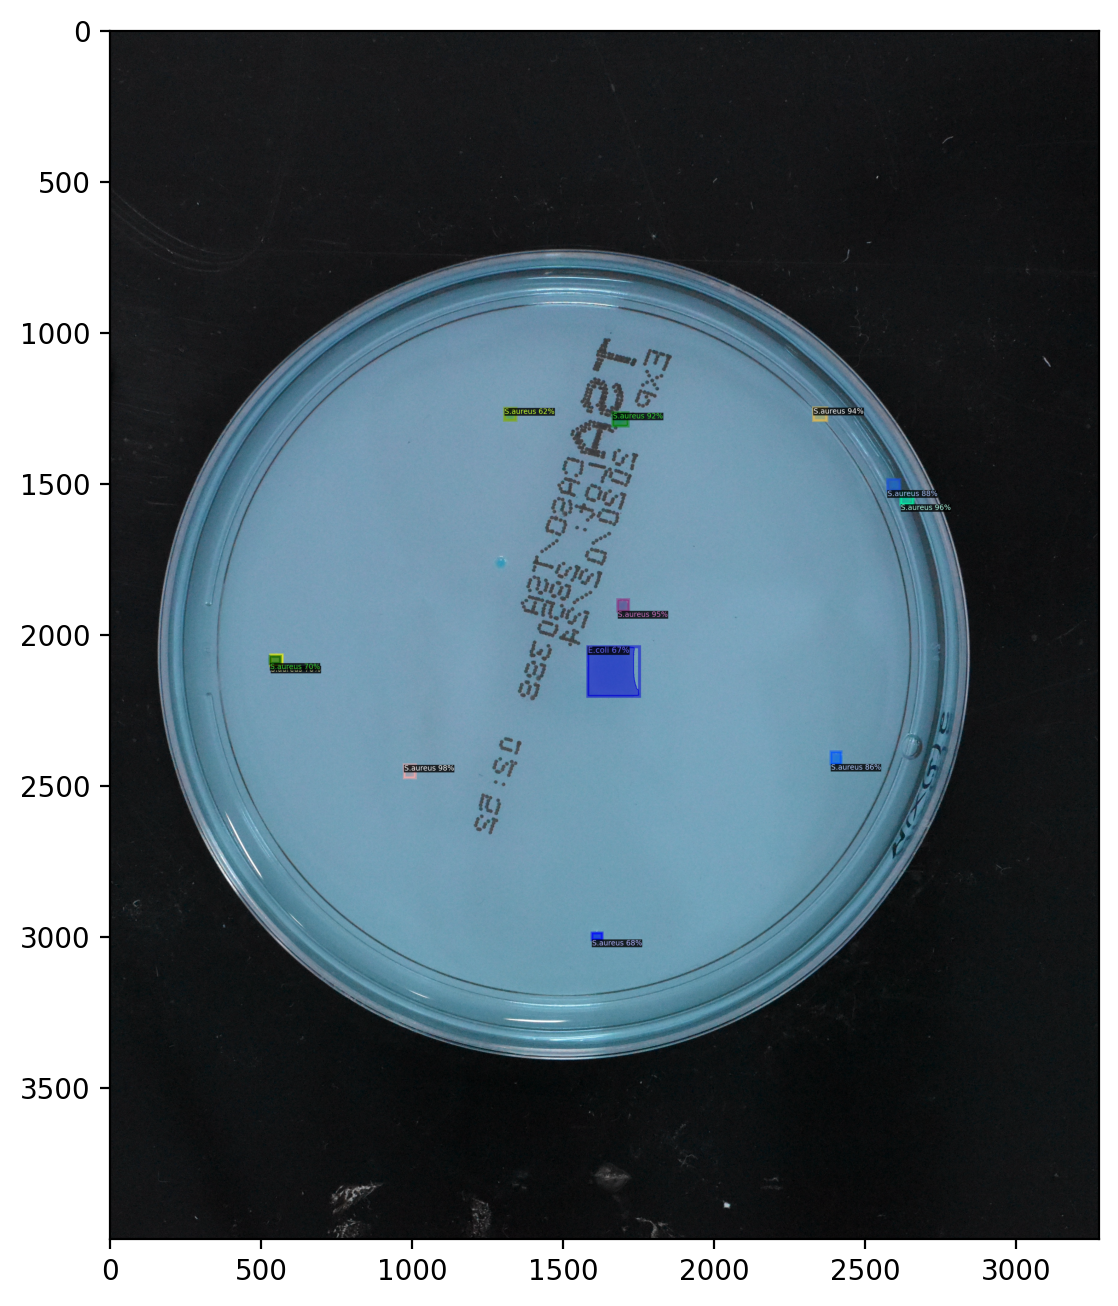

In [ ]:
metadata = MetadataCatalog.get(f"{DATASET_NAME}_high_res_train")
val_datasets = DatasetCatalog.get(f"{DATASET_NAME}_low_res_val") + DatasetCatalog.get(
    f"{DATASET_NAME}_high_res_val") + DatasetCatalog.get(f"{DATASET_NAME}_vague_val")

for d in random.sample(list(val_datasets), 3):
    print(d["file_name"])
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=metadata,
                   scale=1.0)
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.figure(figsize=(8, 8), dpi=200)
    plt.imshow(out.get_image()[:, :, ::-1])
    plt.show()

[04/05 23:57:54 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(1024, 1024), max_size=2048, sample_style='choice')]
[04/05 23:57:54 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[04/05 23:57:54 d2.data.common]: Serializing 1106 elements to byte tensors and concatenating them all ...
[04/05 23:57:54 d2.data.common]: Serialized dataset takes 1.54 MiB


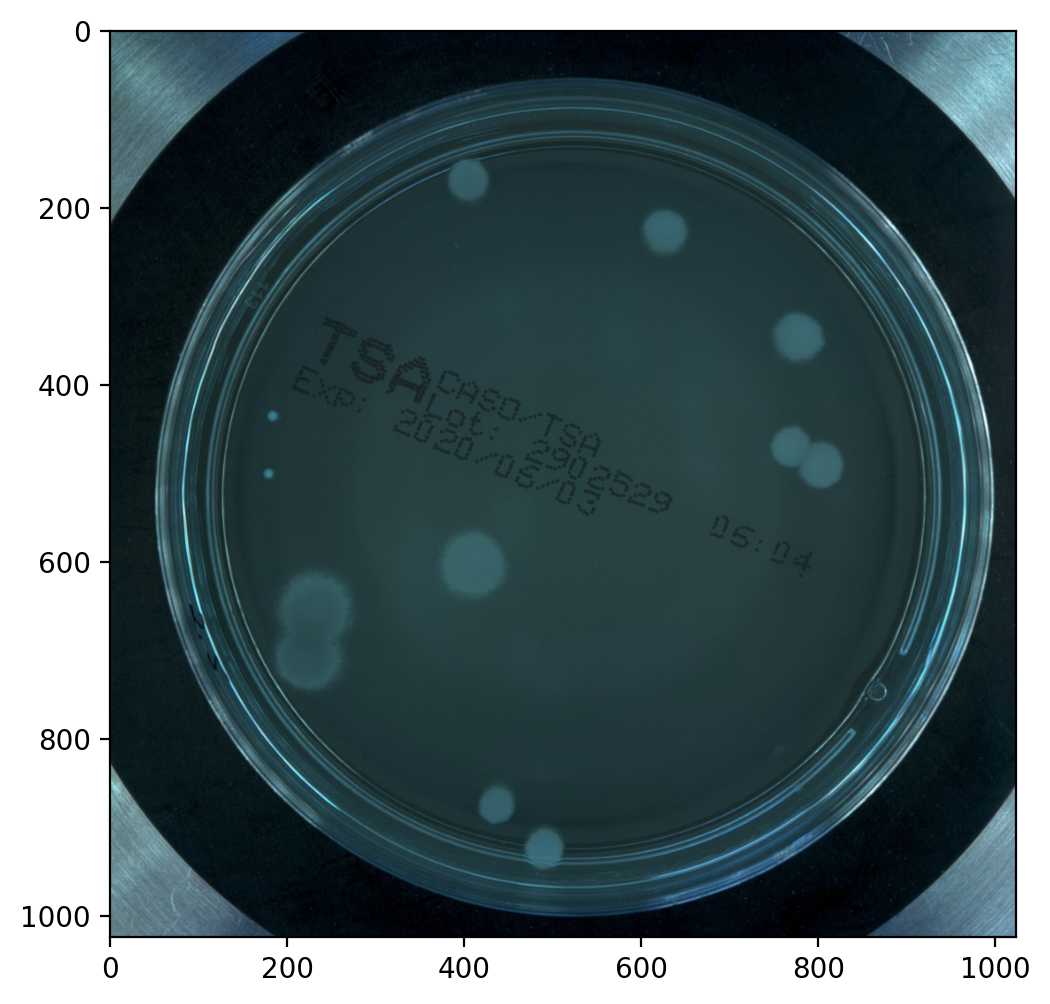

In [ ]:
# изображение после аугментаций (которое поступает на вход нейронке и эвалуатору)
test_loader = build_detection_test_loader(cfg, f"{DATASET_NAME}_low_res_val")
rnd_img = random.choice(test_loader.dataset)['image']

plt.figure(figsize=(6, 6), dpi=200)
plt.imshow(rnd_img.permute(2, 1, 0))
plt.show()

In [ ]:
evaluators = []
for test_ds in cfg.DATASETS.TEST:
    evaluator = COCOEvaluator(test_ds, output_dir=OUTPUT_DIR)
    evaluators.append(evaluator)
test_results = trainer.test(cfg=cfg, model=predictor.model, evaluators=evaluators)
test_results

[04/05 23:57:56 d2.evaluation.coco_evaluation]: Trying to convert 'agar_coco_dataset_high_res_val' to COCO format ...
[04/05 23:57:56 d2.data.datasets.coco]: Converting annotations of dataset 'agar_coco_dataset_high_res_val' to COCO format ...)
[04/05 23:57:56 d2.data.datasets.coco]: Converting dataset dicts into COCO format
[04/05 23:58:06 d2.data.datasets.coco]: Conversion finished, #images: 1747, #annotations: 57973
[04/05 23:58:06 d2.data.datasets.coco]: Caching COCO format annotations at './output/agar_coco_dataset_high_res_val_coco_format.json' ...
[04/05 23:58:17 d2.evaluation.coco_evaluation]: Trying to convert 'agar_coco_dataset_low_res_val' to COCO format ...
[04/05 23:58:17 d2.data.datasets.coco]: Converting annotations of dataset 'agar_coco_dataset_low_res_val' to COCO format ...)
[04/05 23:58:18 d2.data.datasets.coco]: Converting dataset dicts into COCO format
[04/05 23:58:21 d2.data.datasets.coco]: Conversion finished, #images: 1106, #annotations: 21259
[04/05 23:58:21 d2

KeyboardInterrupt: 

In [ ]:
pd.DataFrame(test_results)

agar_coco_dataset_high_res_val  \
bbox  {'AP': 27.1860325674932, 'AP50': 49.9129142904...   

                          agar_coco_dataset_low_res_val  \
bbox  {'AP': 30.91567440524071, 'AP50': 56.123351758...   

                            agar_coco_dataset_vague_val  
bbox  {'AP': 27.892646917260706, 'AP50': 50.48095488...

In [ ]:
pd.DataFrame(test_results['agar_coco_dataset_high_res_val'])

bbox
AP               27.186033
AP-B.subtilis    12.174373
AP-C.albicans    19.209990
AP-E.coli        30.467591
AP-P.aeruginosa  34.804630
AP-S.aureus      39.273579
AP50             49.912914
AP75             27.321320
APl              24.078226
APm              19.494277
APs               4.948586

In [ ]:
pd.DataFrame(test_results['agar_coco_dataset_low_res_val'])

bbox
AP               30.915674
AP-B.subtilis    19.553015
AP-C.albicans    27.786972
AP-E.coli        38.352190
AP-P.aeruginosa  39.189038
AP-S.aureus      29.697157
AP50             56.123352
AP75             30.521547
APl              35.417757
APm              30.706419
APs               6.476145

In [ ]:
pd.DataFrame(test_results['agar_coco_dataset_vague_val'])

bbox
AP               27.892647
AP-B.subtilis          NaN
AP-C.albicans          NaN
AP-E.coli        15.911747
AP-P.aeruginosa  30.082331
AP-S.aureus      37.683862
AP50             50.480955
AP75             28.465065
APl              23.461902
APm              25.033592
APs               8.281244